In [1]:
from data_wrangler import feature_extractor
import numpy as np
import pandas as pd
import tensorflow as tf
from model import atp_pipeline, atp_graph, losses
from data_wrangler import dataset_preparer
from data_wrangler import batcher
import os
import IPython
import matplotlib.pyplot as plt
import numpy as np

In [2]:
exchange = pd.read_csv('datasets/exchange.csv')

In [3]:
array = np.array(exchange)
array[:,0] = np.linspace(-1,1,array.shape[0])
array = array.astype("float32")

In [4]:
exchange

,date,0,1,2,3,4,5,6,OT
0,1990/1/1 0:00,0.785500,1.611000,0.861698,0.634196,0.211242,0.006838,0.525486,0.593000
1,1990/1/2 0:00,0.781800,1.610000,0.861104,0.633513,0.211242,0.006863,0.523972,0.594000
2,1990/1/3 0:00,0.786700,1.629300,0.861030,0.648508,0.211242,0.006975,0.526316,0.597300
3,1990/1/4 0:00,0.786000,1.637000,0.862069,0.650618,0.211242,0.006953,0.523834,0.597000
4,1990/1/5 0:00,0.784900,1.653000,0.861995,0.656254,0.211242,0.006940,0.527426,0.598500
...,...,...,...,...,...,...,...,...,...
7583,2010/10/6 0:00,0.718494,1.222195,0.737485,0.969974,0.143697,0.008500,0.688565,0.690846
7584,2010/10/7 0:00,0.721839,1.223459,0.741155,0.977297,0.143763,0.008595,0.690288,0.695701
7585,2010/10/8 0:00,0.723197,1.234111,0.745184,0.984446,0.143997,0.008562,0.691419,0.695943
7586,2010/10/9 0:00,0.720825,1.233905,0.744131,0.980344,0.143993,0.008555,0.690942,0.692689


In [5]:
x_train, y_train, x_val, y_val, x_test, y_test = dataset_preparer.dataset_processor("datasets/exchange.csv") 


In [6]:
y_train.shape

(5235, 1, 1)

In [7]:
save_dir = 'weights/forecasting/exchange/multivariate'

In [8]:

run = 2
tr_step = atp_graph.build_graph()
model = atp_pipeline.atp_pipeline(multiply=8)
###### can we put the name of the model into the folder name #########?

name_comp = 'run_' + str(run)
folder = save_dir + '/ckpt/check_' + name_comp
if not os.path.exists(folder): os.mkdir(folder)
opt = tf.keras.optimizers.Adam(3e-4)
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=opt, net=model)
manager = tf.train.CheckpointManager(ckpt, folder, max_to_keep=1)
ckpt.restore(manager.latest_checkpoint) 
sum_mse_tot = 0; sum_nll_tot = 0
mini = 50000

Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-05-25 14:53:37.941822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-05-25 14:53:37.941949: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [9]:
n_C, n_T = 96, 96

In [10]:
x, y = batcher.batcher_multi_ts(array[:5000, :], n_C=96, n_T=96) 

In [20]:
m  = atp_pipeline.atp_pipeline(multiply=7, MHAX_leakage='xxx', subsample=False)

In [21]:
y.shape

(32, 1536)

In [22]:
8 * 192

1536

In [23]:
tf.range(7)

<tf.Tensor: shape=(7,), dtype=int32, numpy=array([0, 1, 2, 3, 4, 5, 6], dtype=int32)>

In [25]:
m([x, y[:, :, np.newaxis], [20, 20, 20, 20, 20, 20, 20], [20, 20, 20, 20, 20, 20, 20, 20], True, [20], [10]])

ts_start tf.Tensor(0, shape=(), dtype=int32)
ts_end tf.Tensor(40, shape=(), dtype=int32)
x_temp.shape (32, 40, 1)
ts_start tf.Tensor(40, shape=(), dtype=int32)
ts_end tf.Tensor(80, shape=(), dtype=int32)
x_temp.shape (32, 40, 1)
ts_start tf.Tensor(80, shape=(), dtype=int32)
ts_end tf.Tensor(120, shape=(), dtype=int32)
x_temp.shape (32, 40, 1)
ts_start tf.Tensor(120, shape=(), dtype=int32)
ts_end tf.Tensor(160, shape=(), dtype=int32)
x_temp.shape (32, 40, 1)
ts_start tf.Tensor(160, shape=(), dtype=int32)
ts_end tf.Tensor(200, shape=(), dtype=int32)
x_temp.shape (32, 40, 1)
ts_start tf.Tensor(200, shape=(), dtype=int32)
ts_end tf.Tensor(240, shape=(), dtype=int32)
x_temp.shape (32, 40, 1)
ts_start tf.Tensor(240, shape=(), dtype=int32)
ts_end tf.Tensor(280, shape=(), dtype=int32)
x_temp.shape (32, 40, 1)


(<tf.Tensor: shape=(32, 140, 1), dtype=float32, numpy=
 array([[[5.691631 ],
         [5.358798 ],
         [4.30334  ],
         ...,
         [6.92659  ],
         [6.5222034],
         [5.688397 ]],
 
        [[6.9774666],
         [4.9466057],
         [6.2084284],
         ...,
         [7.5115695],
         [7.5851564],
         [7.225258 ]],
 
        [[7.087231 ],
         [7.2869673],
         [6.0088906],
         ...,
         [8.470135 ],
         [6.9623103],
         [8.042394 ]],
 
        ...,
 
        [[4.7145743],
         [5.6194267],
         [5.6868014],
         ...,
         [7.301817 ],
         [6.0656095],
         [7.263817 ]],
 
        [[4.9648705],
         [5.106922 ],
         [3.4952462],
         ...,
         [6.3624067],
         [5.7304106],
         [6.0163927]],
 
        [[6.097771 ],
         [4.756557 ],
         [4.7459207],
         ...,
         [5.981386 ],
         [5.6481028],
         [7.334259 ]]], dtype=float32)>,
 <tf.Tensor: shape=(

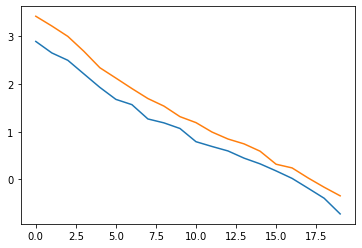

In [17]:
tr_loss = [] ; val_loss = []
n_C2 = n_C * 8
n_T2 = n_T * 8
batch_s = 32
for i in range(2000):
    x, y = batcher_bc(array[:5000, :], n_C, n_T) 
    y_re = np.concatenate([y[:, n_C2 + n_T * i:n_C2+(n_T * (i +1))] for i in range(8)], axis=-1)
    y_re = y_re.reshape(batch_s, -1, 1)
    _,_, nll_pp_tr, _ = tr_step(model, opt, x[:, :, np.newaxis], y, n_C, n_T, training=True, multiple=8, y_re=y_re)
    
    
    if (i+1) % 100 == 0:
        x, y = batcher_bc(array[5000:6000, :], n_C, n_T) 
        y_re = np.concatenate([y[:, n_C2 + n_T * i:n_C2+(n_T * (i +1))] for i in range(8)], axis=-1)
        y_re = y_re.reshape(batch_s, -1, 1)
        mu, log_sigma = model([x[:, :, np.newaxis], y, n_C, n_T, False]) 
        _, _, _, nll_pp_val, mse = losses.nll(y_re, mu, log_sigma)
        if nll_pp_val.numpy() < mini:
            ckpt.step.assign_add(1)
            save_path = manager.save()
            print("Saved checkpoint for step {}: {}".format(int(ckpt.step), save_path))
            print("loss {:1.2f}".format(nll_pp_tr.numpy()))
        tr_loss.append(nll_pp_tr.numpy())
        val_loss.append(nll_pp_val.numpy())
        IPython.display.clear_output(wait=True)
        plt.plot(tr_loss)
        plt.plot(val_loss)
        plt.show()